# Garbage Classification Using Multimodal Deep Learning

This project implements a multimodal deep learning model that classifies garbage categories based on images and text descriptions. By combining visual and textual data, we aim to enhance classification accuracy compared to single-modality approaches.

## Goals:
- Develop a model that can classify garbage categories based on both image and textual descriptions.
- Implement a two-phase training and fine-tuning approach to optimize performance.
- Evaluate model performance using standard metrics like accuracy, precision, recall, and F1-score.


# Imports

In [1]:
import os
import re
import time
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import torchvision
from torchvision import transforms, models
from torchvision.models import ResNet50_Weights

from transformers import BertTokenizer, BertModel
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Initialize Device

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda:0


# Static Global Variables

In [4]:
# hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.0001
DROPOUT_RATE = 0.2

# dataset directories
# change these to your own directories where your data is located
TRAINSET_DIR = '/content/drive/MyDrive/ENEL645/data/enel645_2024f/garbage_data/CVPR_2024_dataset_Train'
VALSET_DIR = '/content/drive/MyDrive/ENEL645/data/enel645_2024f/garbage_data/CVPR_2024_dataset_Val'
TESTSET_DIR = '/content/drive/MyDrive/ENEL645/data/enel645_2024f/garbage_data/CVPR_2024_dataset_Test'

# global class to index mapping variables
class_names = ['Green', 'Blue', 'Black', 'TTR']
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}
idx_to_class = {idx: class_name for class_name, idx in class_to_idx.items()}

# Class Definitions

## GarbageDataset Class
### Data Processing Steps
1. **Image Loading and Transformation**:
   - Each image is loaded and converted to RGB.
   - If specified, transformations like resizing and normalization are applied to prepare the image for the model.
   
2. **Text Tokenization and Caching**:
   - Text descriptions are tokenized using a pre-trained tokenizer.
   - Tokenization results are cached to avoid redundant computations, especially useful for repeated descriptions.
   
3. **Label Encoding**:
   - Textual labels are converted to numeric format using a `class_to_idx` mapping, ensuring labels are compatible with the classification model.

This class is designed to support multimodal learning by enabling the model to process and learn from both image and text data, enhancing its classification capabilities.

In [5]:
"""
**GarbageDataset**

This class loads data from a DataFrame containing image paths, text descriptions, and labels. It applies image
transformations, tokenizes text descriptions, and maps labels to numeric values for training a deep learning model.

Attributes:
    dataframe (pd.DataFrame): The input DataFrame containing 'image_path', 'text_description', and 'label' columns.
    image_transform (callable, optional): Image transformation function to preprocess images.
    max_len (int): Maximum length for text tokenization (default: 32).
    tokenizer (transformers.PreTrainedTokenizer, optional): Tokenizer for text processing.
    class_to_idx (dict): Mapping of class labels to numeric indices for model training.

Methods:
    __len__(): Returns the number of samples in the dataset.
    __getitem__(idx): Retrieves the image, tokenized text, and label for a given index.

        Inputs:
            idx (int): Index of the data sample to retrieve.
        Outputs:
            dict: A dictionary containing:
                - 'image' (torch.Tensor): The preprocessed image tensor.
                - 'input_ids' (torch.Tensor): The tokenized text input IDs.
                - 'attention_mask' (torch.Tensor): Attention mask for tokenized text.
                - 'label' (torch.Tensor): Numeric label for classification.
                - 'text_description' (str): Original text description for reference.
"""
class GarbageDataset(Dataset):
    # Initialize the dataset with a dataframe
    def __init__(self, dataframe, image_transform=None, max_len=32, tokenizer=None, class_to_idx=None):
        self.dataframe = dataframe
        self.image_transform = image_transform
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.class_to_idx = class_to_idx

        # Cache for storing tokenized descriptions to avoid re-tokenizing duplicate descriptions
        self._token_cache = {}

    # Return the number of samples in the dataset
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get image path, text description, and label from the dataframe
        img_path = self.dataframe.iloc[idx]['image_path']
        text_desc = self.dataframe.iloc[idx]['text_description']
        label = self.dataframe.iloc[idx]['label']

        # Load and preprocess the image
        image = Image.open(img_path).convert("RGB")

        # Transform the image
        if self.image_transform:
            image = self.image_transform(image)

        # Tokenize the text description using caching
        if text_desc in self._token_cache:
            text_inputs = self._token_cache[text_desc]
        else:
            text_inputs = self.tokenizer(
                text_desc,
                add_special_tokens=True,
                padding='max_length',
                truncation=True,
                max_length=self.max_len,
                return_token_type_ids=False,
                return_tensors="pt"
            )
            self._token_cache[text_desc] = text_inputs

        # Convert string label to numeric label using the class mapping
        numeric_label = self.class_to_idx[label]

        # Return the image, text input, and numeric label
        return {
            'image': image,
            'input_ids': text_inputs['input_ids'].squeeze(0),
            'attention_mask': text_inputs['attention_mask'].squeeze(0),
            'label': torch.tensor(numeric_label, dtype=torch.long),
            'text_description': text_desc  # For logging misclassified examples
        }

## Model Definition: Multimodal Garbage Classifier

Our model integrates two branches:
1. **Image Model**: Extracts features from garbage images using a pre-trained convolutional neural network (ResNet-50).
2. **Text Model**: Encodes textual descriptions using BERT embeddings.

Both branches' outputs are combined in a fusion layer to produce the final classification prediction.

### Components:
- **Image Branch**: Extracts visual features from garbage images.
- **Text Branch**: Encodes descriptions into meaningful embeddings.
- **Fusion Layer**: Combines image and text features to generate a multimodal representation.

In [6]:
"""
**ImageModel**

This model loads a ResNet-50 model, removes its final classification layer, and replaces it with a custom
feature extraction layer to output a 512-dimensional feature vector for each image. A dropout layer is applied
to prevent overfitting.

Attributes:
    dropout_rate (float): Dropout probability applied in the feature extraction layer (default: 0.5).
    model (torchvision.models.ResNet): Pre-trained ResNet-50 model with the classification layer removed.
    feature_extractor (nn.Sequential): Sequential layers containing a linear transformation, ReLU activation,
        and dropout, which outputs a 512-dimensional feature vector.

Methods:
    forward(x): Passes an input image through the ResNet-50 backbone and feature extractor.

        Inputs:
            x (torch.Tensor): Input image tensor with shape (batch_size, 3, H, W).

        Outputs:
            torch.Tensor: A 512-dimensional feature vector for each input image, with shape (batch_size, 512).
"""
class ImageModel(nn.Module):
    def __init__(self, dropout_rate=0.2):
        # Initialize the model
        super(ImageModel, self).__init__()

        # Load a pre-trained ResNet50 model with default weights
        self.model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

        # Remove the last classification layer
        self.model.fc = nn.Identity()

        # Feature extractor to output a feature vector
        self.feature_extractor = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

    def forward(self, x):
        # Pass the input through the ResNet50 model up to the last layer (output shape: batch_size x 2048)
        x = self.model(x)

        # Process the features and produce a 512-dimensional feature vector
        x = self.feature_extractor(x)
        return x

In [7]:
"""
**TextModel**

This model uses a pre-trained BERT architecture to generate contextual embeddings from text input.
It extracts the representation of the [CLS] token and processes it through a dropout layer and a
linear transformation to produce a 512-dimensional feature vector for classification tasks.

Attributes:
    dropout_rate (float): Dropout probability applied after the [CLS] token extraction (default: 0.5).
    pretrained_model_name (str): The name of the pre-trained BERT model to be used (default: 'bert-base-uncased').
    bert (transformers.BertModel): The BERT model for extracting embeddings.
    dropout (nn.Dropout): Dropout layer for regularization.
    feature_extractor (nn.Linear): Linear layer that reduces the BERT output to a 512-dimensional feature vector.

Methods:
    forward(input_ids, attention_mask): Passes tokenized text input through the BERT model and feature extractor.

        Inputs:
            input_ids (torch.Tensor): Input tensor containing token IDs with shape (batch_size, max_length).
            attention_mask (torch.Tensor): Attention mask tensor indicating valid tokens with shape (batch_size, max_length).

        Outputs:
            torch.Tensor: A 512-dimensional feature vector for each input sequence, with shape (batch_size, 512).
"""
class TextModel(nn.Module):
    # Initialize the TextModel and load a pretrained BERT model
    def __init__(self, dropout_rate=0.5, pretrained_model_name='bert-base-uncased'):
        super(TextModel, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_model_name)

        # Define a dropout layer for regularization
        self.dropout = nn.Dropout(dropout_rate)

        # Define a linear layer to map the BERT output size to a smaller 512-dimensional feature vector
        self.feature_extractor = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        nn.Linear(self.bert.config.hidden_size, 512)

    def forward(self, input_ids, attention_mask):
        # Pass the input IDs and attention mask through the BERT model to get the outputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # Extract the CLS token embedding from the last hidden state (the first token of the output)
        cls_token_embedding = outputs.last_hidden_state[:, 0, :]

        # Apply dropout to the CLS token embedding for regularization
        pooled_output = self.dropout(cls_token_embedding)

        # Pass the pooled output through the feature extractor to obtain the final text features
        text_features = self.feature_extractor(pooled_output)

        return text_features

In [8]:
"""
**GarbageClassifier**

This model integrates features extracted from images using a ResNet-50 backbone and text features using a
BERT model. The output from both models is concatenated and processed through several fully connected layers
to produce class predictions for garbage classification.

Attributes:
    num_classes (int): The number of output classes for classification (default: 4).
    dropout_rate (float): Dropout probability applied in the fusion layers (default: 0.5).
    image_model (ImageModel): Instance of the image feature extraction model.
    text_model (TextModel): Instance of the text feature extraction model.
    fusion (nn.Sequential): Sequential layers for combining features and outputting class predictions.

Methods:
    forward(image, input_ids, attention_mask): Combines image and text features to make class predictions.

        Inputs:
            image (torch.Tensor): Input image tensor with shape (batch_size, 3, H, W).
            input_ids (torch.Tensor): Input tensor containing token IDs with shape (batch_size, max_length).
            attention_mask (torch.Tensor): Attention mask tensor indicating valid tokens with shape (batch_size, max_length).

        Outputs:
            torch.Tensor: Class predictions with shape (batch_size, num_classes).
"""
class GarbageClassifier(nn.Module):
    def __init__(self, num_classes=4, dropout_rate=0.5):
        # Initialize the classifier
        super(GarbageClassifier, self).__init__()

        # Get the image model
        self.image_model = ImageModel(dropout_rate=dropout_rate)

        # Get the text model
        self.text_model = TextModel(dropout_rate=dropout_rate)

        # Delcare the fusion and classification layers
        self.fusion = nn.Sequential(
            nn.Linear(512 + 512, 256),
            #nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, input_ids, attention_mask):
        # Get image features - Shape: (batch_size, 512)
        image_features = self.image_model(image)

        # Get text features (logits) - Shape: (batch_size, num_classes)
        text_features = self.text_model(input_ids, attention_mask)

        # Combined features - Shape: (batch_size, 512 + num_classes)
        combined_features = torch.cat((image_features, text_features), dim=1)

        # Combined prediction - Shape: (batch_size, num_classes)
        combined_output = self.fusion(combined_features)

        return combined_output

In [9]:
"""
UnNormalize class

A class to reverse the normalization applied to images.

This is useful when you need to visualize or process images in their original form after they have
been normalized (e.g., for model training). The class applies the inverse transformation to return
the image to its original scale.
"""

class UnNormalize(object):

    def __init__(self, mean, std):
        """
        Initialize the UnNormalize transformation with the mean and standard deviation used during normalization.

        Args:
            mean (list or tuple): The mean values for each channel used during normalization.
            std (list or tuple): The standard deviation values for each channel used during normalization.
        """
        # Convert mean and std to torch tensors and reshape to match image dimensions (C x 1 x 1)
        self.mean = torch.tensor(mean).view(3, 1, 1)
        self.std = torch.tensor(std).view(3, 1, 1)

    def __call__(self, tensor):
        """
        Apply the un-normalization to a normalized image tensor.

        Args:
            tensor (torch.Tensor): The normalized image tensor to be un-normalized.

        Returns:
            torch.Tensor: The un-normalized image tensor with values clamped between 0 and 1.
        """
        # Move mean and std to the same device as tensor
        mean = self.mean.to(tensor.device)
        std = self.std.to(tensor.device)

        # Reverse the normalization: multiply by std and add mean
        tensor = tensor * std + mean
        # Clamp the tensor values to be within the valid image range [0, 1]
        return torch.clamp(tensor, 0, 1)

# Function Definitions

### Extracting Data

1. **Directory Traversal**:
   - The function iterates through each subfolder in the base directory. Each subfolder is expected to represent a distinct class, named according to the class label.

2. **File Filtering and Path Extraction**:
   - Within each subfolder, the function filters for image files (JPEG, PNG formats) and constructs the full file path for each.

3. **Text Description Generation**:
   - Filenames are used as initial descriptions. Extensions are removed, and underscores (`_`) are replaced with spaces.
   - Digits are removed from filenames to yield cleaner descriptions, which are then converted to lowercase.

4. **Data Compilation**:
   - Each image’s path, generated text description, and corresponding class label are stored in a dictionary and appended to a list.
   - Finally, the list of dictionaries is converted into a pandas DataFrame, facilitating easy data manipulation and access for model training.

### Example DataFrame Structure

| image_path           | text_description    | label       |
|----------------------|---------------------|-------------|
| `path/to/image_a_1.jpg` | `image a`      | `label1`    |
| `path/to/image_b_2.png` | `image b`   | `label2`    |

This DataFrame can then be used for further data preprocessing, such as tokenizing text descriptions and creating data loaders for model training.

In [10]:
"""
**extract_data_from_folders**

This function traverses through a specified base directory containing subfolders. Each subfolder represents a
distinct class label, and it extracts image file paths, generates text descriptions from the filenames, and
associates them with their respective labels. The resulting data is compiled into a pandas DataFrame for
convenient processing and manipulation.

Args:
    base_dir (str): The path to the base directory containing subfolders with images.

Returns:
    pd.DataFrame: A DataFrame containing the extracted information with columns:
        - 'image_path': Path to the image file.
        - 'text_description': A text description generated from the filename, cleaned of digits and underscores.
        - 'label': The name of the subfolder, representing the class label for the images.
"""
def extract_data_from_folders(base_dir):
    data = []

    # Traverse through each subfolder
    for label_folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, label_folder)

        # Check if it's a directory
        if os.path.isdir(folder_path):
            # Loop through each image file in the subfolder
            for filename in os.listdir(folder_path):
                # Filter through image files
                if filename.endswith(('.jpg', '.png', '.jpeg')):
                    image_path = os.path.join(folder_path, filename)

                    # Extract text from filename (remove file extension)
                    text_description = os.path.splitext(filename)[0]

                    # Append image path, text, and label to the data list
                    text = text_description.replace('_', ' ')
                    text_without_digits = re.sub(r'\d+', '', text).strip().lower()
                    data.append({
                        'image_path': image_path,
                        'text_description': text_without_digits,
                        # The subfolder name represents the label
                        'label': label_folder
                    })

    # Convert to DataFrame for easy manipulation
    return pd.DataFrame(data)

In [11]:
"""
**compute_class_weights**

This function calculates weights for each class based on their frequency in the training dataset.
It uses the `compute_class_weight` function from sklearn to generate weights that can be used
to mitigate the impact of imbalanced class distribution during training. The resulting weights
are returned as a tensor for use in model training.

Args:
    trainset_df (pd.DataFrame): DataFrame containing the training dataset with a column 'label'
                                    representing the class labels.

Returns:
    torch.Tensor: A tensor containing the computed class weights, where each weight corresponds
                    to a class in the dataset.
"""
def compute_class_weights(trainset_df):
    # Extract unique class labels from the 'label' column of the training set DataFrame.
    class_labels = np.unique(trainset_df['label'])

    # Calculate the class weights using the compute_class_weight function from sklearn.
    class_weights = compute_class_weight(
        'balanced',
        classes=class_labels,
        y=trainset_df['label']
    )

    # Create a mapping from class labels to their corresponding weights.
    class_weights_dict = {label: weight for label, weight in zip(class_labels, class_weights)}

    # Map the class weights to the class indices defined in the variable class_names.
    class_weights_list = [class_weights_dict[class_name] for class_name in class_names]

    # Convert the list of class weights into a PyTorch tensor and move it to the specified device (CPU or GPU).
    class_weights_tensor = torch.tensor(class_weights_list, dtype=torch.float).to(device)

    return class_weights_tensor

In [12]:
"""
**data_preprocessing**

This function handles the following tasks:
1. Extracts image paths, text descriptions, and labels from specified directories for training, validation,
    and test datasets.
2. Computes class weights to address class imbalance.
3. Initializes the BERT tokenizer for text processing.
4. Defines image transformations for both training and testing datasets.
5. Creates instances of the `GarbageDataset` class for each dataset.
6. Initializes DataLoaders for efficient batching and shuffling of the datasets.

Returns:
    tuple: A tuple containing:
        - trainloader (DataLoader): DataLoader for the training dataset.
        - valloader (DataLoader): DataLoader for the validation dataset.
        - testloader (DataLoader): DataLoader for the test dataset.
        - class_weights_tensor (torch.Tensor): Tensor containing the computed class weights.
"""
def data_preprocessing():
    # Extract the data from the specified directories for training, validation, and testing
    trainset_df = extract_data_from_folders(TRAINSET_DIR)
    valset_df = extract_data_from_folders(VALSET_DIR)
    testset_df = extract_data_from_folders(TESTSET_DIR)

    # Compute class weights to address any class imbalance in the training set
    class_weights_tensor = compute_class_weights(trainset_df)

    # Initialize the BERT tokenizer for processing text data
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Define image transformations for the training set, including resizing, data augmentation, and normalization
    transform_train = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
        transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally for augmentation
        transforms.RandomRotation(10),  # Randomly rotate images by up to 10 degrees for augmentation
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),  # Convert PIL images to PyTorch tensors
        transforms.Normalize(  # Normalize the images with specified mean and standard deviation values
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    # Define image transformations for the test set, which do not include augmentation
    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
        transforms.ToTensor(),  # Convert PIL images to PyTorch tensors
        transforms.Normalize(  # Normalize the images with specified mean and standard deviation values
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    # Create datasets for training, validation, and testing using the GarbageDataset class
    trainset = GarbageDataset(
        trainset_df,
        image_transform=transform_train,
        class_to_idx=class_to_idx,
        tokenizer=tokenizer,
        max_len=32
    )
    valset = GarbageDataset(
        valset_df,
        image_transform=transform_train,
        class_to_idx=class_to_idx,
        tokenizer=tokenizer,
        max_len=32
    )
    testset = GarbageDataset(
        testset_df,
        image_transform=transform_test,
        class_to_idx=class_to_idx,
        tokenizer=tokenizer,
        max_len=32
    )

    # Create DataLoader objects for training, validation, and testing, specifying batch size and number of workers
    trainloader = DataLoader(
        trainset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=12
    )
    valloader = DataLoader(
        valset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=12
    )
    testloader = DataLoader(
        testset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=12
    )

    # Return the DataLoader objects and the class weights tensor for use in training and evaluation
    return trainset_df, valset_df, testset_df, trainloader, valloader, testloader, class_weights_tensor

In [13]:
"""
**compute_metrics**

This function calculates precision, recall, and F1-score using the true labels and predicted labels.
The metrics are computed using the `precision_score`, `recall_score`, and `f1_score` functions from
sklearn, with a focus on the weighted average to account for class imbalance.

Args:
    all_labels (list or np.ndarray): True labels for the dataset.
    all_preds_combined (list or np.ndarray): Predicted labels from the model.

Returns:
    tuple: A tuple containing:
        - precision (float): The precision score of the predictions.
        - recall (float): The recall score of the predictions.
        - f1 (float): The F1 score of the predictions.
"""
def compute_metrics(all_labels, all_preds_combined):
    # Calculate precision, using a 'weighted' average to account for class imbalance
    precision = precision_score(
        all_labels, all_preds_combined, average='weighted', zero_division=0
    )

    # Calculate recall, which measures the ability of the model to find all the relevant instances
    recall = recall_score(
        all_labels, all_preds_combined, average='weighted', zero_division=0
    )

    # Calculate the F1 score, which is the harmonic mean of precision and recall
    f1 = f1_score(
        all_labels, all_preds_combined, average='weighted', zero_division=0
    )

    # Return the computed precision, recall, and F1 score
    return precision, recall, f1

In [14]:
"""
**plot_training_results**

This function generates a 2x2 grid of plots to visualize the training and validation metrics
across epochs. It handles both tensor and NumPy array inputs, ensuring compatibility with
GPU tensors by moving them to the CPU.

Args:
    train_losses (list): A list of training loss values for each epoch.
    val_losses (list): A list of validation loss values for each epoch.
    train_accuracies (list): A list of training accuracy values for each epoch.
    val_accuracies (list): A list of validation accuracy values for each epoch.
    precisions (list): A list of precision values for each epoch.
    recalls (list): A list of recall values for each epoch.
    f1_scores (list): A list of F1 scores for each epoch.

Returns:
    None
"""
def plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies, precisions, recalls, f1_scores):
    # Convert list of tensors to NumPy arrays if they are on GPU to enable plotting
    train_losses = [loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in train_losses]
    val_losses = [loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in val_losses]
    train_accuracies = [acc.detach().cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in train_accuracies]
    val_accuracies = [acc.detach().cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in val_accuracies]
    precisions = [precision.detach().cpu().numpy() if isinstance(precision, torch.Tensor) else precision for precision in precisions]
    recalls = [recall.detach().cpu().numpy() if isinstance(recall, torch.Tensor) else recall for recall in recalls]
    f1_scores = [f1.detach().cpu().numpy() if isinstance(f1, torch.Tensor) else f1 for f1 in f1_scores]

    # Create a list of epochs corresponding to the number of training iterations
    epochs = range(1, len(train_losses) + 1)
    epochs = list(epochs)

    # Plot Loss
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Precision
    plt.subplot(2, 2, 3)
    plt.plot(epochs, precisions, label='Precision')
    plt.title('Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    # Plot Recall and F1 Score
    plt.subplot(2, 2, 4)
    plt.plot(epochs, recalls, label='Recall')  #
    plt.plot(epochs, f1_scores, label='F1 Score')
    plt.title('Validation Recall and F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()

    # adjust layout, save file, and close to save memory
    plt.tight_layout()
    plt.show()

In [15]:
"""
**plot_confusion_matrix**

This function generates a heatmap visualization of the confusion matrix using Seaborn.
The matrix shows the number of correct and incorrect predictions for each class, allowing
for an intuitive understanding of the model's performance.

Args:
    conf_mat (ndarray): A confusion matrix, typically computed from the test set predictions.

Returns:
    None
"""
def plot_confusion_matrix(conf_mat):
    # Create a figure and axis for the confusion matrix plot
    fig, ax = plt.subplots(figsize=(6, 6))

    # Use seaborn's heatmap to visualize the confusion matrix
    sns.heatmap(
        conf_mat,  # The confusion matrix to plot
        annot=True,  # Annotate each cell with the numeric value
        fmt='d',  # Format of the annotation as integers
        cmap='Blues',  # Color map for the heatmap
        xticklabels=class_names,  # X-axis labels as class names for predicted labels
        yticklabels=class_names  # Y-axis labels as class names for actual labels
    )

    # Add title and axis lables
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Test Confusion Matrix')

    plt.show()

## Training and Validation Functions

### Train One Epoch
This function handles a single training epoch:
- Performs a forward pass for each batch.
- Computes the combined loss from image and text data.
- Updates model parameters using backpropagation.

### Validation
The validation function evaluates the model after each epoch:
- Calculates loss, accuracy, precision, recall, and F1-score.
- Tracks the best-performing model to enable early stopping.

These functions ensure the model learns effectively while monitoring validation performance.


In [16]:
"""
**train_one_epoch**

This function performs a single training pass over the provided dataset. It iterates through
the training data, performs forward and backward passes, computes the loss, and updates the model weights.
The function also tracks the running loss and accuracy for the epoch.

Args:
    model (nn.Module): The model to be trained.
    trainloader (DataLoader): The DataLoader for the training dataset.
    criterion (nn.Module): The loss function used for training.
    optimizer (torch.optim.Optimizer): The optimizer used for updating model weights.

Returns:
    tuple: A tuple containing:
        - epoch_loss_combined (float): The average loss for the epoch.
        - epoch_acc_combined (float): The average accuracy for the epoch.
"""
def train_one_epoch(model, trainloader, criterion, optimizer):
    # Set the model to training mode
    model.train()

    # Initialize variables to track the cumulative loss and correct predictions
    running_loss_combined = 0.0
    running_corrects_combined = 0

    # Iterate over the training data provided by the DataLoader
    for _, batch in enumerate(trainloader):
        # Move images and labels to specified device
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Clear the gradients of the optimizer before each forward pass
        optimizer.zero_grad()

        # Forward pass through the model
        combined_outputs = model(
            images, input_ids, attention_mask
        )

        # Compute the loss using the specified criterion
        loss_combined = criterion(combined_outputs, labels)

        # Backward pass to compute gradients and optimize the model
        loss_combined.backward()
        optimizer.step()

        # Update the cumulative loss with the loss from this batch
        running_loss_combined += loss_combined.item() * images.size(0)

        # Get predictions by selecting the class with the highest score
        _, preds_combined = torch.max(combined_outputs, 1)

        # Update the count of correct predictions
        running_corrects_combined += torch.sum(preds_combined == labels.data)

    # Compute epoch loss and accuracy for the epoch
    epoch_loss_combined = running_loss_combined / len(trainloader.dataset)
    epoch_acc_combined = running_corrects_combined.double() / len(trainloader.dataset)

    return epoch_loss_combined, epoch_acc_combined

In [17]:
"""
**validate**

This function evaluates the model's performance on the validation set by calculating the validation loss,
accuracy, and additional metrics such as precision, recall, and F1 score. It uses the model in evaluation mode
and disables gradient computation to save memory and improve performance during inference.

Args:
    model (nn.Module): The neural network model to validate.
    valloader (DataLoader): The DataLoader for the validation dataset.
    criterion (nn.Module): The loss function used to compute loss.

Returns:
    tuple: A tuple containing:
        - float: The computed validation loss.
        - float: The computed validation accuracy.
        - float: The computed precision.
        - float: The computed recall.
        - float: The computed F1 score.
"""
def validate(model, valloader, criterion):
    # Set the model to evaluation mode, disabling dropout and batch normalization
    model.eval()

    val_running_loss_combined = 0.0  # Initialize the total loss for the validation set
    val_running_corrects_combined = 0  # Initialize the count of correct predictions

    all_labels = []  # List to store all true labels for metrics computation
    all_preds_combined = []  # List to store all predictions for metrics computation

    # Disable gradient calculation for validation (saves memory and computation)
    with torch.no_grad():
        for batch in valloader:
            # Move data to the appropriate device
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Forward pass: compute model outputs for the current batch
            combined_outputs = model(
                images, input_ids, attention_mask
            )

            # Compute the loss between predicted outputs and true labels
            loss_combined = criterion(combined_outputs, labels)

            # Update the running loss for the validation set
            val_running_loss_combined += loss_combined.item() * images.size(0)

            # Get predictions by finding the class with the maximum score
            _, preds_combined = torch.max(combined_outputs, 1)

            # Update the count of correct predictions
            val_running_corrects_combined += torch.sum(
                preds_combined == labels.data
            )

            # Collect all labels and predictions for metric computations
            all_labels.extend(labels.cpu().numpy())
            all_preds_combined.extend(preds_combined.cpu().numpy())

    # Compute the average validation loss and accuracy
    val_loss_combined = val_running_loss_combined / len(valloader.dataset)
    val_acc_combined = val_running_corrects_combined.double() / len(valloader.dataset)

    # Compute additional metrics such as precision, recall, and F1 score
    precision, recall, f1 = compute_metrics(all_labels, all_preds_combined)

    # Return the computed validation loss, accuracy, and metrics
    return val_loss_combined, val_acc_combined, precision, recall, f1

In [18]:
"""
**train_validate_model**

This function handles the entire training process for a given model, including training and
validation phases. It tracks the loss and accuracy metrics for both phases, implements early stopping
based on validation loss, and saves the best-performing model. A learning rate scheduler is also used
to adjust the learning rate during training.

Args:
    model (nn.Module): The neural network model to be trained and validated.
    trainloader (DataLoader): The DataLoader for the training dataset.
    valloader (DataLoader): The DataLoader for the validation dataset.
    criterion (nn.Module): The loss function used to compute loss.
    trainable_params (iterable): An iterable of parameters to optimize.
    best_val_loss (float): The best validation loss encountered during training.
    num_epochs (int): The total number of epochs to train the model.

Returns:
    float: The best validation loss achieved during training.
"""
def train_validate_model(model, trainloader, valloader, criterion, trainable_params, best_val_loss, num_epochs):
    # Initialize the Adam optimizer with a learning rate and weight decay for regularization
    optimizer = optim.Adam(trainable_params, lr=LEARNING_RATE, weight_decay=1e-4)

    # Parameters for early stopping to prevent overfitting.=
    early_stopping_patience = 5  # Number of epochs to wait before stopping if no improvement
    epochs_no_improve = 0  # Counter for epochs without improvement in validation loss

    # Lists to store training and validation metrics for plotting later
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    # Learning rate scheduler to reduce the learning rate after a certain number of epochs
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    # Loop through the specified number of epochs for training and validation
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Training phase: call the training function for one epoch
        epoch_loss_combined, epoch_acc_combined = train_one_epoch(
            model, trainloader, criterion, optimizer
        )

        # Append training metrics to the respective lists
        train_losses.append(epoch_loss_combined)
        train_accuracies.append(epoch_acc_combined)

        print(f'Training Combined Loss: {epoch_loss_combined:.4f} '
                f'Acc: {epoch_acc_combined:.4f}')

        # Validation phase: evaluate the model on the validation set
        val_loss_combined, val_acc_combined, precision, recall, f1 = validate(
            model, valloader, criterion
        )

        # Append validation metrics to the respective lists
        val_losses.append(val_loss_combined)
        val_accuracies.append(val_acc_combined)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        print(f'Validation Combined Loss: {val_loss_combined:.4f} '
                f'Acc: {val_acc_combined:.4f}')
        print(f'Validation Precision: {precision:.4f}, '
                f'Recall: {recall:.4f}, F1-score: {f1:.4f}')

        # Early stopping: check if the validation loss has improved
        if val_loss_combined < best_val_loss:
            best_val_loss = val_loss_combined  # Update the best validation loss
            epochs_no_improve = 0  # Reset the counter

            # Save the model state if a new best validation loss is found
            print(f"New best model found! Saving model with validation "
                    f"loss: {best_val_loss:.4f}")
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1  # Increment the counter for epochs without improvement
            if epochs_no_improve >= early_stopping_patience:  # Check if patience limit is reached
                print(f'Early stopping at epoch {epoch + 1} due to {epochs_no_improve} epochs without improvement')  # Print a message indicating early stopping
                break  # Exit the training loop

        # Step the learning rate scheduler to adjust the learning rate
        scheduler.step()

    # Plotting results: save the metrics to a file for analysis
    plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies, precisions, recalls, f1_scores)

    return best_val_loss  # Return the best validation loss achieved during training

In [19]:
"""
**test**

This function evaluates the model's performance on the test set by calculating the test accuracy
and additional metrics such as precision, recall, and F1 score. It also identifies and logs misclassified
examples, allowing for further analysis of the model's performance.

Args:
    model (nn.Module): The neural network model to test.
    testloader (DataLoader): The DataLoader for the test dataset.

Returns:
    tuple: A tuple containing:
        - float: The computed test accuracy.
        - float: The computed precision.
        - float: The computed recall.
        - float: The computed F1 score.
        - ndarray: The confusion matrix.
"""
def test(model, testloader):
     # Set the model to evaluation mode, disabling dropout and batch normalization
    model.eval()

    test_running_corrects_combined = 0  # Initialize the count of correct predictions

    all_labels = []  # List to store all true labels for metrics computation
    all_preds_combined = []  # List to store all predictions for metrics computation

    misclassified_examples = []  # List to store misclassified examples for analysis

    # Instantiate the UnNormalize transform
    unnormalize = UnNormalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])

    # Disable gradient calculation for testing (saves memory and computation)
    with torch.no_grad():
        for batch in testloader:
            # Move data to the appropriate device
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            text_desc = batch['text_description']

            # Forward pass: compute model outputs for the current batch
            combined_outputs = model(
                images, input_ids, attention_mask
            )

            # Get predictions by finding the class with the maximum score
            _, preds_combined = torch.max(combined_outputs, 1)

            # Update the count of correct predictions
            test_running_corrects_combined += torch.sum(
                preds_combined == labels.data
            )

            # Collect all labels and predictions for metric computations
            all_labels.extend(labels.cpu().numpy())
            all_preds_combined.extend(preds_combined.cpu().numpy())

            # Identify misclassified examples for further analysis
            for img, pred_label, true_label, text in zip(images, preds_combined, labels, text_desc):
                if pred_label != true_label and len(misclassified_examples) < 10:
                    # Unnormalize the image for visualization
                    img_normal = unnormalize(img)
                    # Convert the image tensor to a NumPy array
                    img_pil = transforms.ToPILImage()(img_normal)
                    # Append the image, predicted label, true label, and text description to the list
                    misclassified_examples.append({
                        "Image": img_pil,
                        "Predicted Label": idx_to_class[pred_label.item()],
                        "True Label": idx_to_class[true_label.item()],
                        "Text Description": text
                    })



    # Compute test accuracy
    test_acc_combined = test_running_corrects_combined.double() / len(testloader.dataset)

    # Compute additional metrics like precision, recall, and F1 score
    precision, recall, f1 = compute_metrics(all_labels, all_preds_combined)

    # Compute confusion matrix for detailed error analysis
    conf_mat = confusion_matrix(all_labels, all_preds_combined)

    # Return test accuracy and computed metrics
    return test_acc_combined, precision, recall, f1, conf_mat, misclassified_examples

# Main Functions

## Pre-process data, define criterion, and initialize the multimodal model


In [20]:
# Preprocess data and create data loaders
trainset_df, valset_df, testset_df, trainloader, valloader, testloader, class_weights_tensor = data_preprocessing()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Take to look at the distribution of the dataset

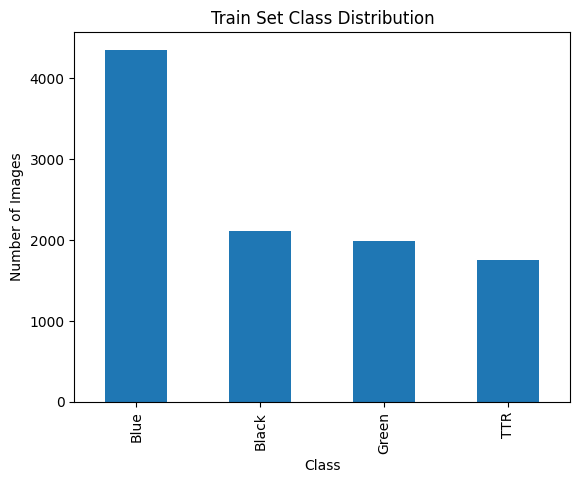

In [21]:
# Train Set
class_counts = trainset_df['label'].value_counts()
class_counts.plot(kind='bar')
plt.title('Train Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

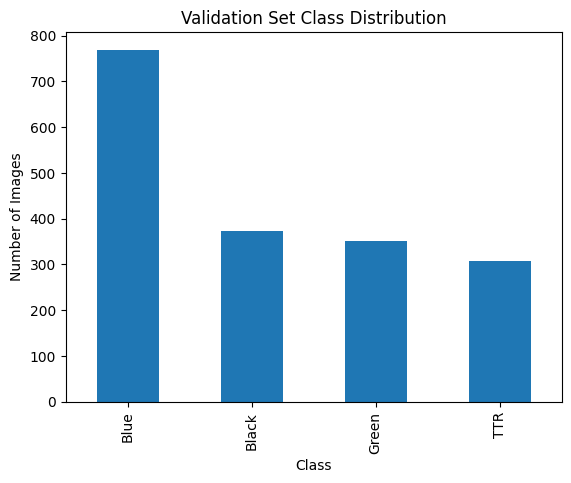

In [22]:
# Validation Set
class_counts = valset_df['label'].value_counts()
class_counts.plot(kind='bar')
plt.title('Validation Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

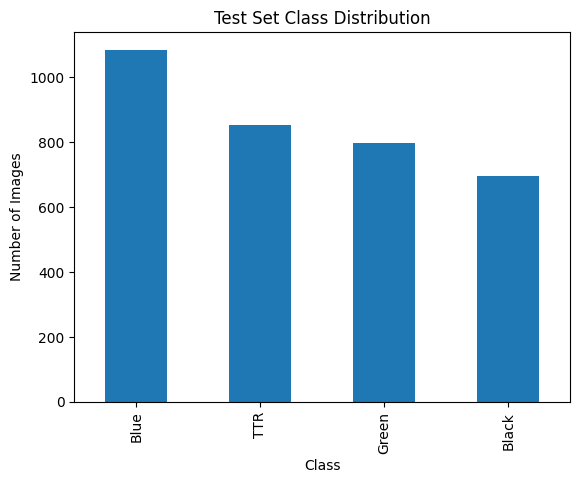

In [23]:
# Test Set
class_counts = testset_df['label'].value_counts()
class_counts.plot(kind='bar')
plt.title('Test Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

As shown, the training and validation datasets contain significantly more items labeled as blue than those in other classes. This imbalance may skew the model and lead to biased training. To address this, we will mitigate the issue by ensuring balanced class distribution during training.

In [24]:
# Define the loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Initialize the model
model = GarbageClassifier(num_classes=len(class_names), dropout_rate=DROPOUT_RATE).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 119MB/s]


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## Create the trainable parameters

In [25]:
# Freeze layers of the image model and unfreeze specific layers for training
for param in model.image_model.model.parameters():
    param.requires_grad = False  # Freeze all layers initially
for param in model.image_model.model.layer4.parameters():
    param.requires_grad = True  # Unfreeze layer4 for training
for param in model.image_model.feature_extractor.parameters():
    param.requires_grad = True  # Unfreeze feature extractor for training

# Unfreeze layers of the text model for training
for param in model.text_model.bert.parameters():
    param.requires_grad = True
for param in model.text_model.feature_extractor.parameters():
    param.requires_grad = True

# Collect trainable parameters with specific learning rates
trainable_params = [
    {'params': model.image_model.model.layer4.parameters(), 'lr': LEARNING_RATE * 0.1},
    {'params': model.image_model.feature_extractor.parameters(), 'lr': LEARNING_RATE},
    {'params': model.text_model.bert.parameters(), 'lr': LEARNING_RATE * 0.1},
    {'params': model.text_model.feature_extractor.parameters(), 'lr': LEARNING_RATE},
    {'params': model.fusion.parameters(), 'lr': LEARNING_RATE},
]

## Iterate through the first phase of training

## Training Phases

### First Training Phase
In this phase:
- Only specific layers of the image model are unfrozen.
- Both text and image branches undergo training, optimizing model weights gradually.
- Early stopping is employed to avoid overfitting.

### Fine-tuning Phase
- Additional layers in the image model are unfrozen for fine-tuning.
- A lower learning rate is used for stability.
- Fine-tuning refines the model by focusing on nuanced patterns within the data.

By combining training and fine-tuning, we enhance model performance while preventing overfitting.


Epoch 1/20
----------
Training Combined Loss: 0.6172 Acc: 0.7741
Validation Combined Loss: 0.3528 Acc: 0.8690
Validation Precision: 0.8718, Recall: 0.8690, F1-score: 0.8698
New best model found! Saving model with validation loss: 0.3528
Epoch 2/20
----------
Training Combined Loss: 0.3030 Acc: 0.8833
Validation Combined Loss: 0.3158 Acc: 0.8862
Validation Precision: 0.8920, Recall: 0.8862, F1-score: 0.8873
New best model found! Saving model with validation loss: 0.3158
Epoch 3/20
----------
Training Combined Loss: 0.2322 Acc: 0.9112
Validation Combined Loss: 0.2891 Acc: 0.9001
Validation Precision: 0.9019, Recall: 0.9001, F1-score: 0.9005
New best model found! Saving model with validation loss: 0.2891
Epoch 4/20
----------
Training Combined Loss: 0.1791 Acc: 0.9285
Validation Combined Loss: 0.3013 Acc: 0.8973
Validation Precision: 0.9010, Recall: 0.8973, F1-score: 0.8979
Epoch 5/20
----------
Training Combined Loss: 0.1701 Acc: 0.9318
Validation Combined Loss: 0.3020 Acc: 0.8923
Valida

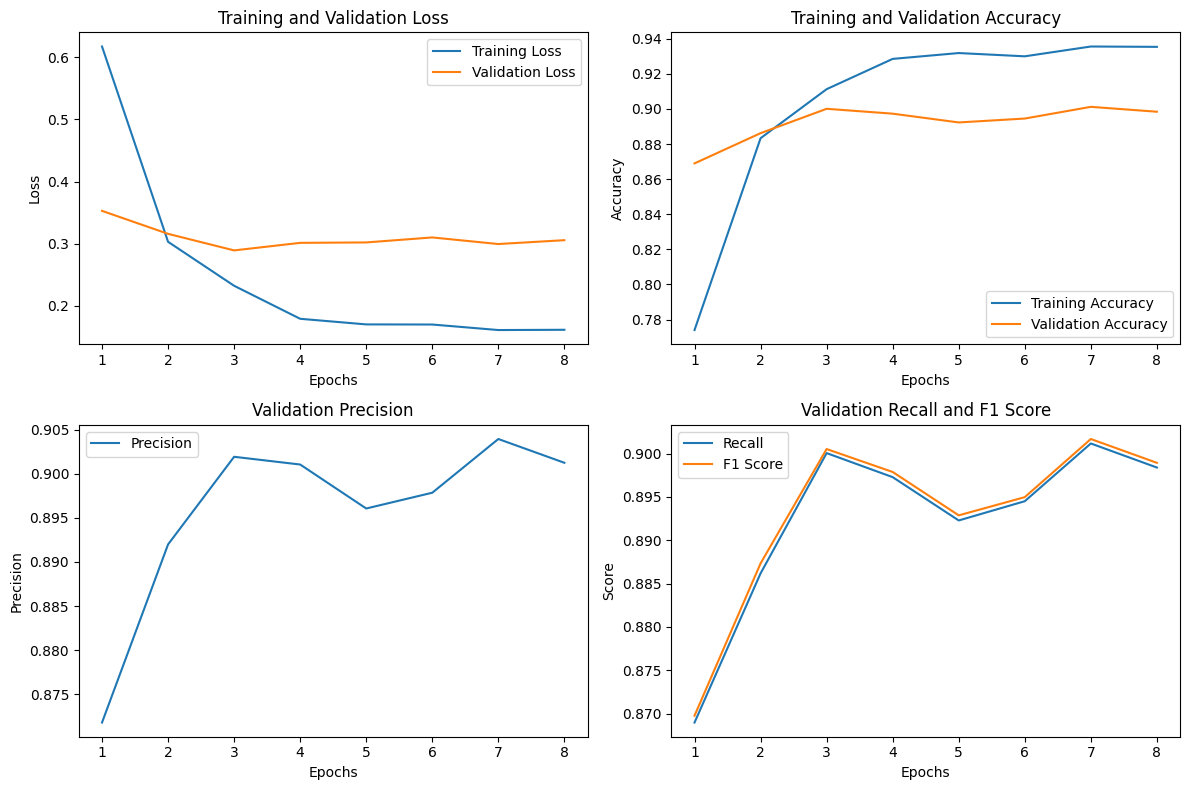

Training completed in 1015.02 seconds.


In [26]:
# Initialize best validation loss
best_val_loss = float('inf')

# Start timing
start_time = time.time()

# First phase of training
best_val_loss = train_validate_model(model, trainloader, valloader, criterion, trainable_params, best_val_loss, 20)

# End timing
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Log the elapsed time
print(f"Training completed in {elapsed_time:.2f} seconds.")

## Load best model for fine-tuning

In [27]:
# Load the best model after first phase of training
model.load_state_dict(torch.load('best_model.pth', weights_only=True))

<All keys matched successfully>

## Create the trainable parameters for fine-tuning

In [28]:
# Freeze and unfreeze layers for further training
for param in model.image_model.model.parameters():
    param.requires_grad = False  # Freeze all layers again
for param in model.image_model.model.layer2.parameters():
    param.requires_grad = True  # Unfreeze layer2 for training
for param in model.image_model.model.layer3.parameters():
    param.requires_grad = True  # Unfreeze layer3 for training
for param in model.image_model.model.layer4.parameters():
    param.requires_grad = True  # Keep layer4 unfrozen
for param in model.image_model.feature_extractor.parameters():
    param.requires_grad = True  # Keep feature extractor unfrozen

# Unfreeze layers of the text model again for training
for param in model.text_model.bert.parameters():
    param.requires_grad = True
for param in model.text_model.feature_extractor.parameters():
    param.requires_grad = True

# Collect trainable parameters for the second phase with adjusted learning rates
trainable_params = [
    {'params': model.image_model.model.layer2.parameters(), 'lr': LEARNING_RATE * 0.01},
    {'params': model.image_model.model.layer3.parameters(), 'lr': LEARNING_RATE * 0.01},
    {'params': model.image_model.model.layer4.parameters(), 'lr': LEARNING_RATE * 0.01},
    {'params': model.image_model.feature_extractor.parameters(), 'lr': LEARNING_RATE * 0.1},
    {'params': model.text_model.bert.parameters(), 'lr': LEARNING_RATE * 0.01},
    {'params': model.text_model.feature_extractor.parameters(), 'lr': LEARNING_RATE * 0.01},
    {'params': model.fusion.parameters(), 'lr': LEARNING_RATE},
]

## Iterate through the second phase of training

Epoch 1/15
----------
Training Combined Loss: 0.1740 Acc: 0.9300
Validation Combined Loss: 0.3109 Acc: 0.8956
Validation Precision: 0.8982, Recall: 0.8956, F1-score: 0.8959
Epoch 2/15
----------
Training Combined Loss: 0.1677 Acc: 0.9335
Validation Combined Loss: 0.3320 Acc: 0.8917
Validation Precision: 0.8961, Recall: 0.8917, F1-score: 0.8925
Epoch 3/15
----------
Training Combined Loss: 0.1575 Acc: 0.9370
Validation Combined Loss: 0.3238 Acc: 0.8934
Validation Precision: 0.8969, Recall: 0.8934, F1-score: 0.8940
Epoch 4/15
----------
Training Combined Loss: 0.1505 Acc: 0.9381
Validation Combined Loss: 0.3112 Acc: 0.9023
Validation Precision: 0.9045, Recall: 0.9023, F1-score: 0.9027
Epoch 5/15
----------
Training Combined Loss: 0.1491 Acc: 0.9399
Validation Combined Loss: 0.3153 Acc: 0.9006
Validation Precision: 0.9032, Recall: 0.9006, F1-score: 0.9011
Early stopping at epoch 5 due to 5 epochs without improvement


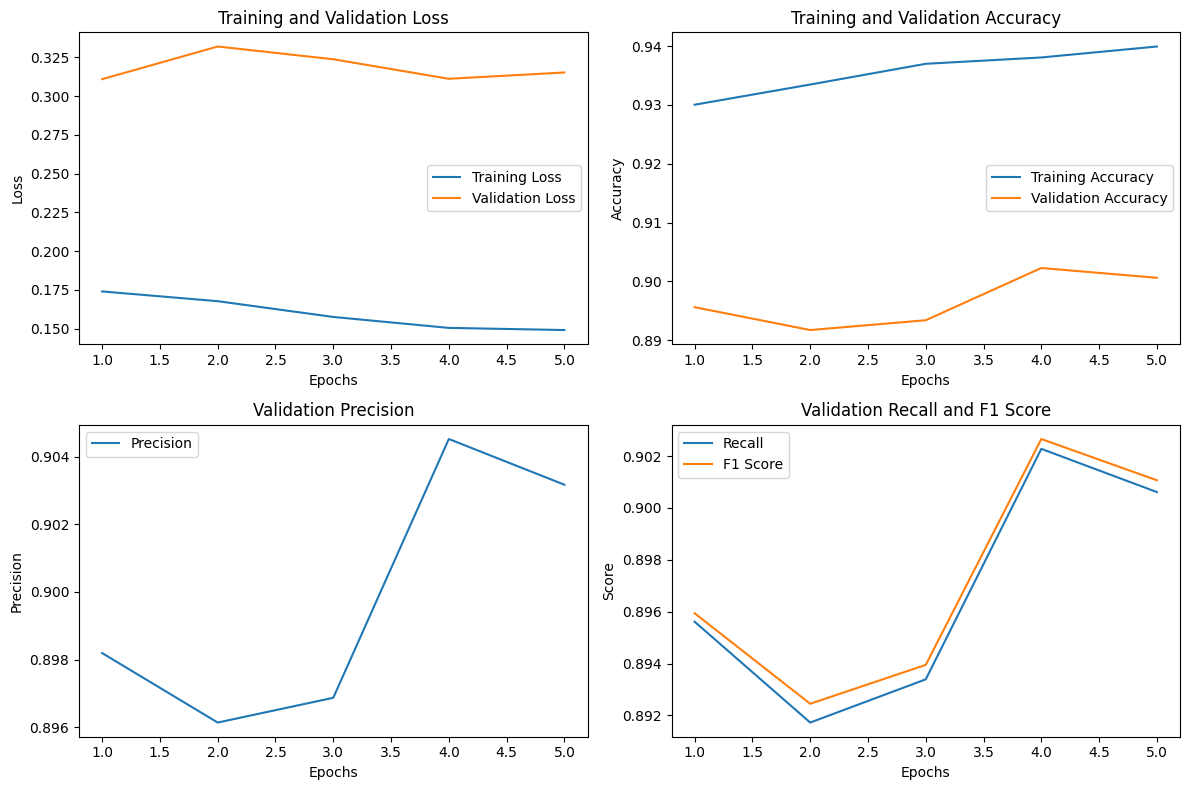

Training completed in 479.09 seconds.


In [29]:
# Start timing
start_time = time.time()

# Second phase of training
train_validate_model(model, trainloader, valloader, criterion, trainable_params, best_val_loss, 15)

# End timing
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Log the elapsed time
print(f"Training completed in {elapsed_time:.2f} seconds.")

## Load best model for testing

In [30]:
# Load the best model after the second phase of training
model.load_state_dict(torch.load('best_model.pth', weights_only=True))

<All keys matched successfully>

## Test the model

## Model Testing

After training, the best model is tested on the test set:
- Accuracy, precision, recall, and F1-score are computed.
- A confusion matrix is generated for detailed performance analysis.

Testing allows us to understand the model's generalization ability and its effectiveness in classifying unseen garbage data.


In [31]:
# Start timing
start_time = time.time()

# Evaluate the model on the test set
test_acc_combined, precision, recall, f1, conf_mat, misclassified_examples = test(model, testloader)

# Print test results
print(f'Test Combined Accuracy: {test_acc_combined:.4f}')
print(f'Test Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

# End timing
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Log the elapsed time
print(f"Testing completed in {elapsed_time:.2f} seconds.")

Test Combined Accuracy: 0.8470
Test Precision: 0.8457, Recall: 0.8470, F1-score: 0.8456
Testing completed in 95.35 seconds.


## Results Visualization

### Confusion Matrix
The confusion matrix provides insights into:
- Model accuracy per class.
- Classes where misclassifications are common.

By visualizing the confusion matrix, we can pinpoint areas for potential improvement in the model.


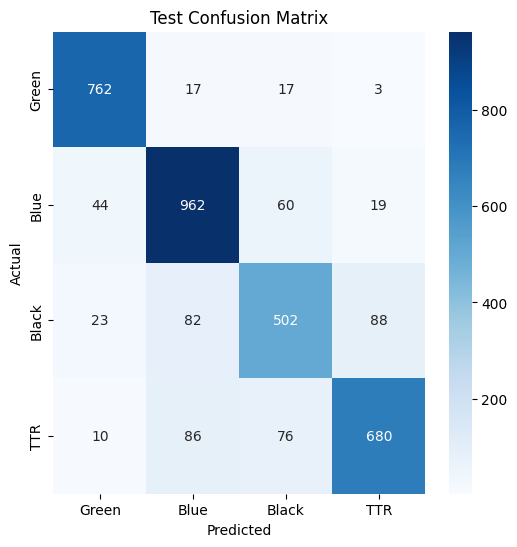

In [34]:
# Plot confusion matrix
plot_confusion_matrix(conf_mat)

### Table of some of the misclassified samples

,Image,Predicted Label,True Label,Text Description
0,,Blue,Green,used sourcream container
1,,Blue,Green,takeout container
2,,Black,Green,packaged sausages
3,,TTR,Green,particle board
4,,Blue,Green,cardboard box with food residue
5,,TTR,Green,rose
6,,Black,Green,used wipes
7,,Black,Green,vitamin gummies
8,,Black,Green,stir stick
9,,TTR,Green,cup coaster

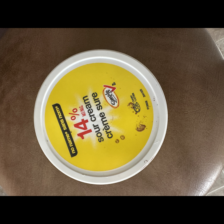
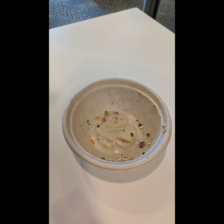
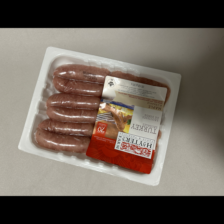
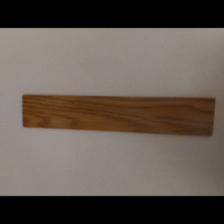
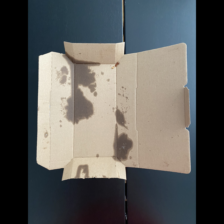
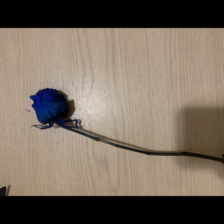
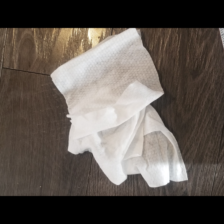
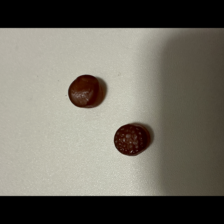
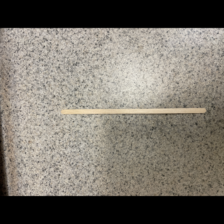
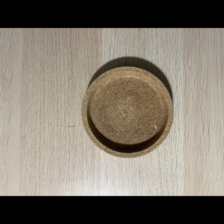

In [35]:
# Create a DataFrame from the misclassified examples
from IPython.display import display, HTML
from io import BytesIO
import base64

def pil_to_base64(img):
    buffer = BytesIO()
    img.save(buffer, format='PNG')
    img_str = base64.b64encode(buffer.getvalue()).decode('utf-8')
    return img_str

# Assuming misclassified_examples is already populated
df = pd.DataFrame(misclassified_examples)
df['Image'] = df['Image'].apply(lambda x: f'<img src="data:image/png;base64,{pil_to_base64(x)}"/>')

display(HTML(df.to_html(escape=False)))

#### Comments on the results
Generally, if a text includes food or other organic items (like "rose"), the classifier tends to mark it as green, even if the image shows the item in a plastic container. For example, it identified sausages as green despite them being wrapped in a plastic container, which means they would go in the black bin. In this case, the text description influences the classification more heavily than the image itself. This suggests areas for improvement in our training data: specifically, we need more detailed text descriptions that include the material of the container and more diverse images of items in plastic. This would help the model learn that plastic items, even those containing organic matter, should not be placed in the green bin.